In [11]:
import numpy as np
from keras import layers, models
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from pathlib import Path
import pandas as pd
from skimage.io import imread
from tensorflow.keras.optimizers import SGD

In [12]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(3072)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
data_dir = Path('D:\Git\Research Paper\DataSet - Mehedi Hasan, Medical Technologist, Bangladesh Hospitals\Project')
train_dir = data_dir / 'Train'
test_dir = data_dir / 'Test'

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,  
                                   rotation_range=50,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest',
                                    validation_split=0.2)

In [6]:
i = 0
for batch in train_datagen.flow_from_directory(train_dir, batch_size=64,target_size=(256,256),
                          save_to_dir='D:\Git\Research Paper\DataSet - Mehedi Hasan, Medical Technologist, Bangladesh Hospitals\Augmented', save_format='jpg'):
    i += 1
    if i > 5:
        break

Found 8132 images belonging to 2 classes.


In [5]:
train_set= train_datagen.flow_from_directory(train_dir,
                                                    target_size=(300, 300),
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True)
#validation data
validation_set = train_datagen.flow_from_directory(train_dir,
                                                        target_size=(300, 300),
                                                        batch_size=64,
                                                        class_mode='categorical',
                                                        subset='validation',
                                                        shuffle=True)

Found 6506 images belonging to 2 classes.
Found 1626 images belonging to 2 classes.


In [6]:
dataiter = iter(train_set)
images, labels = dataiter.next()
images[0].shape

(300, 300, 3)

[1. 0.]


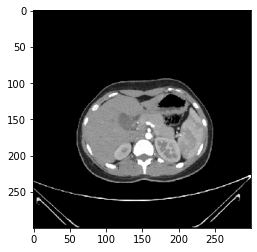

In [7]:
plt.imshow(images[1])
print(labels[1])

In [10]:
opt = SGD(learning_rate=1e-1, momentum=0.9, decay=1e-1 / 45)

In [13]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)) ,
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [14]:


model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6193038438545523029
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3221225472
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17636630626307484220
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [15]:
callback = EarlyStopping('loss', patience=3)

In [16]:
history = model.fit(train_datagen.flow_from_directory(train_dir,
                                                    target_size=(300, 300),
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True),
                    epochs=45,
                    batch_size=64,
                    callbacks = [callback],
                    #verbose = 0,
                    validation_data=train_datagen.flow_from_directory(train_dir,
                                                        target_size=(300, 300),
                                                        batch_size=64,
                                                        class_mode='categorical',
                                                        subset='validation',
                                                        shuffle=True))

Found 6506 images belonging to 2 classes.
Found 1626 images belonging to 2 classes.
Epoch 1/45
102/102 [==============================] - 256s 2s/step - loss: 0.5757 - accuracy: 0.7395 - val_loss: 0.5713 - val_accuracy: 0.7417
Epoch 2/45
102/102 [==============================] - 205s 2s/step - loss: 0.5725 - accuracy: 0.7415 - val_loss: 0.5717 - val_accuracy: 0.7417
Epoch 3/45
102/102 [==============================] - 209s 2s/step - loss: 0.5721 - accuracy: 0.7415 - val_loss: 0.5722 - val_accuracy: 0.7417
Epoch 4/45
102/102 [==============================] - 210s 2s/step - loss: 0.5727 - accuracy: 0.7415 - val_loss: 0.5713 - val_accuracy: 0.7417
Epoch 5/45
102/102 [==============================] - 211s 2s/step - loss: 0.5717 - accuracy: 0.7415 - val_loss: 0.5732 - val_accuracy: 0.7417
Epoch 6/45
102/102 [==============================] - 208s 2s/step - loss: 0.5724 - accuracy: 0.7415 - val_loss: 0.5714 - val_accuracy: 0.7417
Epoch 7/45
102/102 [==============================] - 206s

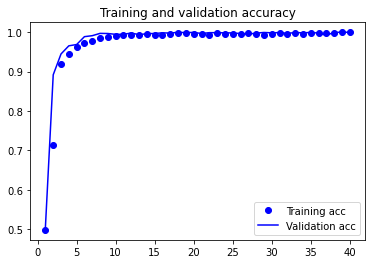

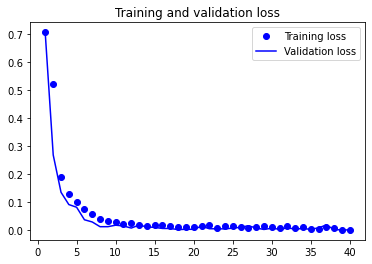

In [35]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
#plotting training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [40]:
y_pred= model.predict(np.array(y_test))

y_true= y_test.classes

cnf_matrix= confusion_matrix(y_true,y_pred.argmax(axis=1))
print('Confusion Matrix:\n',cnf_matrix)

ValueError: in user code:

    File "d:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "d:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "d:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "d:\Anaconda\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\Anaconda\envs\tensorflow\lib\site-packages\keras\engine\input_spec.py", line 228, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential" (type Sequential).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 1)
    
    Call arguments received by layer "sequential" (type Sequential):
      • inputs=tf.Tensor(shape=(None, 1), dtype=int64)
      • training=False
      • mask=None


In [42]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(data_dir,
                                                  target_size=(224, 224),
                                                  batch_size=100,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 8244 images belonging to 3 classes.
